# Text classification HW (aka NLP_2)

Sergei Babushkin, GSOM

## 1. Data preparation

In [115]:
# loading libraries
import os
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
import nltk
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

In [48]:
# creating a dataframe using texts and lables
df = pd.DataFrame()

# initializing variables
texts = []
labels = []

In [49]:
# scanning all the files in the dataset
for subdir, dirs, files in os.walk('C:/Users/valkm/Documents/NL&IP/NLP_2/bbc'):
    for file in files:
        with open(os.path.join(subdir, file), 'r') as doc:
            texts.append(' '.join(doc.readlines()).replace('\n', ''))
        labels.append(subdir.split('\\')[-1])

df['Content'] = texts
df['Category'] = labels

In [50]:
# exporting the data into CSV file
export_csv = df.to_csv ('C:/Users/valkm/Documents/NL&IP/NLP_2/bbc_dataset.csv', index = None, header=True)

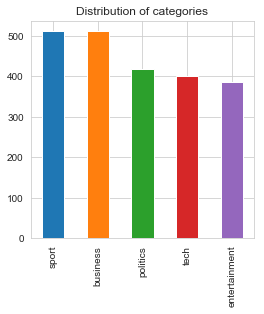

In [57]:
# visualizing the distribution
df['Category'].value_counts().plot(kind = 'bar', figsize = (4, 4))
plt.title('Distribution of categories')
plt.show()

According to the bar chart we can observe that the classes are approximately balanced, so we can train the models without under- or oversampling.

## 2. Feature engineering

In [65]:
#  visualizing one sample news content
df.loc[1]['Content']

'Dollar gains on Greenspan speech  The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.  And Alan Greenspan highlighted the US government\'s willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan\'s speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman\'s taking a much more sanguine view on the current account deficit than he\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He\'s taking a longer-term view, laying out a set of conditions under

In [68]:
# lowercasing the text
df['Content'] = df['Content'].str.lower()

In [78]:
# removing the punctuation signs
punctuation_signs = list("?:!.,;")

for punct_sign in punctuation_signs:
    df['Content'] = df['Content'].str.replace(punct_sign, '')

In [79]:
# getting rid of posessive pronouns
df['Content'] = df['Content'].str.replace("'s", "")

In [82]:
# downloading the stop words list
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valkm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
# coding the labels
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

df['Category_Code'] = df['Category']
df = df.replace({'Category_Code':category_codes})

In [90]:
# splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df['Content'], 
                                                    df['Category_Code'], 
                                                    test_size=0.2)

In [92]:
# setting TF-IDF Vectors as features
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [95]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1780, 300)
(445, 300)


## 3. Model training

Accuracy seems to be the best metric to measure the performance of a model for such task as it works well when there are equal number of samples belonging to each class, just like in our case. For this task I will choose K Nearest Neighbors model.

In [99]:
# checking model's hyperparameters
knnc_0 =KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


In [100]:
# creating the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# creating a base model and splits
knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# instantiating the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# fitting the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.1min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192, 197, 202, 207, 212, 217, 222, 227, 232, 237, 242, 247, 253, 258, 263, 268, 273, 278, 283, 288, 293,...404, 409, 414, 419, 424, 429, 434, 439, 444, 449, 454, 459, 464, 469, 474, 479, 484, 489, 494, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [101]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 11}

The mean accuracy of a model with these hyperparameters is:
0.9155328798185941


In [102]:
# covering all possible n_neighbors near to 11
n_neighbors = [6,7,8,9,10,11,12,13,14,15,16]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   35.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [103]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 11}

The mean accuracy of a model with these hyperparameters is:
0.9155328798185941


In [104]:
best_knnc = grid_search.best_estimator_
best_knnc

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

## 4. Model fit and performance

In [107]:
# fitting the model to the training data
best_knnc.fit(features_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [108]:
# getting the predictions
knnc_pred = best_knnc.predict(features_test)

In [109]:
# training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

The training accuracy is: 
0.9353932584269663


In [110]:
# test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.903370786516854


In [111]:
# classification report
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
             precision    recall  f1-score   support

          0       0.92      0.88      0.90        96
          1       0.94      0.85      0.89        87
          2       0.84      0.95      0.89        78
          3       0.94      0.97      0.95       105
          4       0.87      0.86      0.87        79

avg / total       0.91      0.90      0.90       445



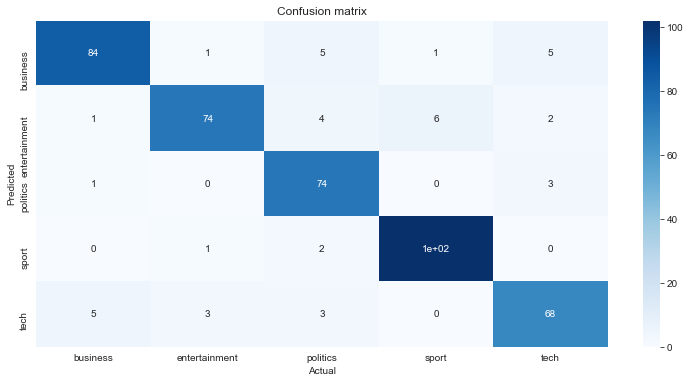

In [112]:
# confusion matrix
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, knnc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [113]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.8943820224719101

In [114]:
best_knnc.fit(features_train, labels_train)
accuracy_score(labels_test, best_knnc.predict(features_test))

0.903370786516854

Here we see that hyperparameter tuning process has returned a better model.